In [21]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [22]:
EV_Stations = pd.DataFrame(pd.read_csv('EV_stations.csv'))
EV_Vehicles = pd.DataFrame(pd.read_csv('predicted_vehicles.csv'))

# Filter the 'Latitude' column of the dataframe to only include values greater than 30
EV_Stations = EV_Stations.loc[EV_Stations['Latitude'] > 30]

# View the resulting dataframe
EV_Stations

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
0,US,AK,99801,58.354895,-134.495377,NaN,2.0,NaN,72524,2/1/15,public,UTILITY,NaN
1,US,AK,99801,58.298366,-134.404006,NaN,2.0,NaN,81601,2/1/17,public,PARKING_GARAGE,NaN
2,US,AK,99801,58.363727,-134.575550,NaN,1.0,NaN,85589,8/1/15,public,OFFICE_BLDG,HYDRO
3,US,AK,99518,61.169369,-149.911144,NaN,2.0,NaN,88609,11/30/17,public,NaN,NaN
4,US,AK,99669,60.494658,-151.045242,NaN,3.0,NaN,112694,11/27/17,public,RESTAURANT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53888,US,WY,82930,41.254635,-110.969556,NaN,NaN,4.0,214279,4/19/22,public,NaN,NaN
53889,US,WY,82414,44.534583,-109.027233,NaN,1.0,NaN,220411,6/1/22,public,NaN,NaN
53890,US,WY,82520,42.834423,-108.745422,NaN,2.0,NaN,220959,6/8/22,public,NaN,NaN
53891,US,WY,83001,43.477678,-110.764935,NaN,NaN,1.0,225937,8/20/22,public,NaN,NaN


In [23]:
EV_Stations = EV_Stations[EV_Stations['State']=='WA']
EV_Stations.head()

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
51405,US,WA,98503,47.044011,-122.822404,NaN,4.0,NaN,33351,1/15/18,public,MUNI_GOV,NaN
51406,US,WA,98188,47.443377,-122.296229,36.0,NaN,NaN,33717,3/1/10,public,AIRPORT,NaN
51407,US,WA,98502,47.035421,-122.938962,2.0,NaN,NaN,35337,8/15/09,public,GROCERY,NaN
51408,US,WA,99252,47.673347,-117.388933,1.0,2.0,NaN,35620,4/15/10,public,OFFICE_BLDG,NaN
51409,US,WA,99201,47.654998,-117.425025,NaN,4.0,NaN,35621,4/15/10,public,RESTAURANT,NaN


In [24]:
EV_Vehicles = EV_Vehicles.drop(columns='Unnamed: 0')

In [25]:
EV_Vehicles

,Year,Total_Sold
0,2010,3.0
1,2011,13.0
2,2012,14.0
3,2013,19.0
4,2014,17.0
5,2015,32.0
6,2016,38.0
7,2017,64.0
8,2018,100.0
9,2019,147.0


In [26]:
features = ['ZIP', 'Latitude', 'Longitude', 'Access Code','Open Date',"ID"]
EV_Stations = EV_Stations[features]
EV_Stations.head()

,ZIP,Latitude,Longitude,Access Code,Open Date,ID
51405,98503,47.044011,-122.822404,public,1/15/18,33351
51406,98188,47.443377,-122.296229,public,3/1/10,33717
51407,98502,47.035421,-122.938962,public,8/15/09,35337
51408,99252,47.673347,-117.388933,public,4/15/10,35620
51409,99201,47.654998,-117.425025,public,4/15/10,35621


In [27]:
EV_Stations.drop_duplicates(subset = "ID",keep = False, inplace= True) ##dropping duplicate vins
EV_Stations.head()

,ZIP,Latitude,Longitude,Access Code,Open Date,ID
51405,98503,47.044011,-122.822404,public,1/15/18,33351
51406,98188,47.443377,-122.296229,public,3/1/10,33717
51407,98502,47.035421,-122.938962,public,8/15/09,35337
51408,99252,47.673347,-117.388933,public,4/15/10,35620
51409,99201,47.654998,-117.425025,public,4/15/10,35621


In [28]:
# Replace all occurrences of "public" with the value 1 in the "Access Codes" column
EV_Stations['Access Code'] = EV_Stations['Access Code'].replace("public", 1)
EV_Stations['Access Code'] = EV_Stations['Access Code'].replace("private", 0)
EV_Stations.head()

,ZIP,Latitude,Longitude,Access Code,Open Date,ID
51405,98503,47.044011,-122.822404,1,1/15/18,33351
51406,98188,47.443377,-122.296229,1,3/1/10,33717
51407,98502,47.035421,-122.938962,1,8/15/09,35337
51408,99252,47.673347,-117.388933,1,4/15/10,35620
51409,99201,47.654998,-117.425025,1,4/15/10,35621


In [29]:
y=EV_Stations['Open Date'].values

for i in range(len(y)):
    y[i] = int(y[i].split("/")[-1])
len(y)

1835

In [30]:
for i in range(len(y)):
    EV_Stations.assign(Year = y[i])

In [31]:
EV_Stations

,ZIP,Latitude,Longitude,Access Code,Open Date,ID
51405,98503,47.044011,-122.822404,1,18,33351
51406,98188,47.443377,-122.296229,1,10,33717
51407,98502,47.035421,-122.938962,1,9,35337
51408,99252,47.673347,-117.388933,1,10,35620
51409,99201,47.654998,-117.425025,1,10,35621
...,...,...,...,...,...,...
53236,98198,47.418161,-122.292929,1,22,225989
53237,98121,47.614387,-122.351622,1,22,226068
53238,98516,47.050128,-122.823353,1,22,226079
53239,98052,47.663672,-122.098617,1,22,226087


In [32]:
def findingyears(year):
    x=np.where(EV_Stations == year)
    return x

In [33]:
#findingyears(7)

In [34]:
arr = [8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
arr1 = []

for i in range(len(arr)):
    x = findingyears(arr[i])
    x = np.array(x)
    arr1.append(x.size/2)
#EV_Title_Year.insert(loc = 2, column = "Number of EV", value = arr1)
arr1

[1.0,
 2.0,
 7.0,
 57.0,
 38.0,
 16.0,
 38.0,
 65.0,
 81.0,
 97.0,
 106.0,
 174.0,
 206.0,
 683.0,
 264.0]

In [35]:
zipped = list(zip(arr, arr1))
df = pd.DataFrame(zipped, columns=['Year', 'Total_Installed'])
df.head()
total_installed=arr1

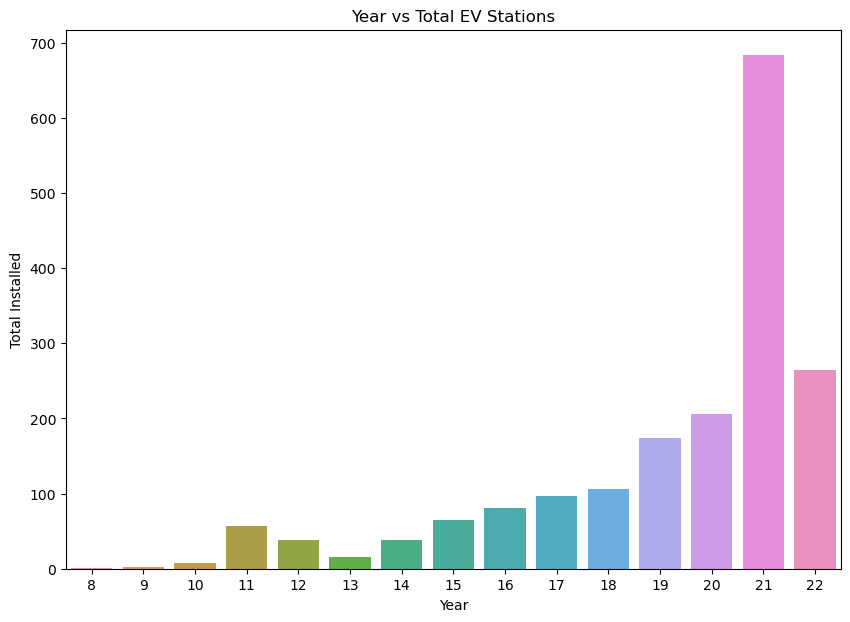

In [36]:
fig=plt.figure(figsize = (10, 7))
sns.barplot(x="Year", y="Total_Installed", data=df)
plt.title('Year vs Total EV Stations')
plt.xlabel('Year')
plt.ylabel('Total Installed')
plt.show()

fig.savefig('Bar Year vs Total EV Stations.jpg', bbox_inches='tight', dpi=150)

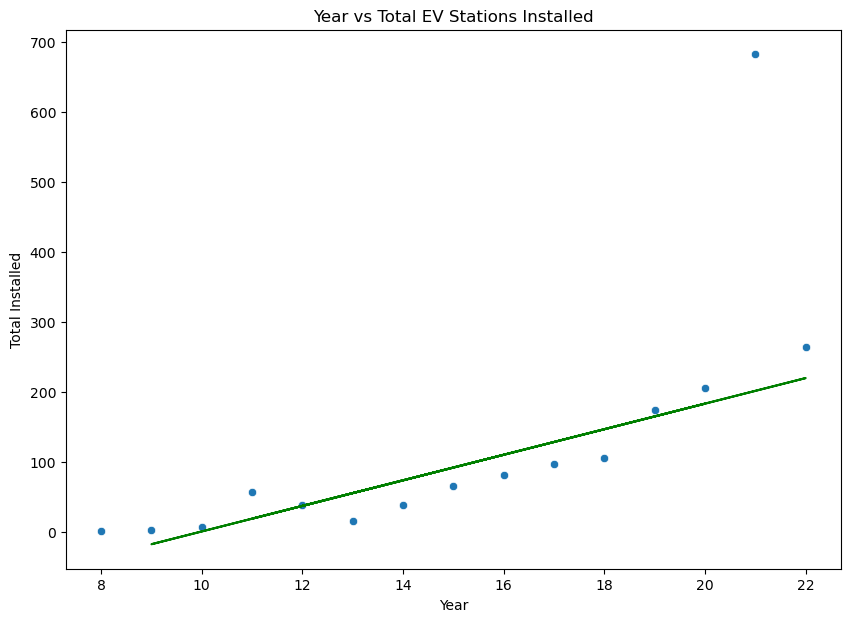

In [37]:
X=np.array(df["Year"].values)
y=np.array(df["Total_Installed"].values)

X=X.reshape(-1,1)
y=y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
x = [23,24,25,26,27,28,29,30,31,32,33]

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(X_test)
X_norm = min_max_scaler.transform(X)

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(X_train) 
xtest = sc_x.transform(X_test)

from sklearn import datasets, linear_model, metrics

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score

classifier = linear_model.LinearRegression()
classifier.fit(X_train, y_train)

classifier.predict(X_train)

x=X_train
y=y_train
n = np.size(x)

y_pred = classifier.predict(X_train)
fig=plt.figure(figsize = (10, 7))
plt.title('Year vs Total EV Stations Installed')
sns.scatterplot(x="Year", y="Total_Installed", data=df)
plt.plot(x,y_pred, color = 'green')
plt.xlabel('Year')
plt.ylabel('Total Installed')

fig.savefig('Year Total EV Stations Predictions.jpg', bbox_inches='tight', dpi=150)

In [38]:
x=X_train
y=y_train
n = np.size(x)

# Fit the data(train the model)
classifier.fit(x, y)
  
# Predict
y_predicted = classifier.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
  
# printing values
print('Slope:' ,classifier.coef_)
print('Intercept:', classifier.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[18.27865961]]
Intercept: [-182.2962963]
MSE: 886.2391534391534
Root mean squared error:  29.769769119681687
R2 score:  0.8650966972163299


[[238.11287478]
 [256.39153439]
 [274.670194  ]
 [292.94885362]
 [311.22751323]
 [329.50617284]
 [347.78483245]
 [366.06349206]
 [384.34215168]
 [402.62081129]
 [420.8994709 ]]


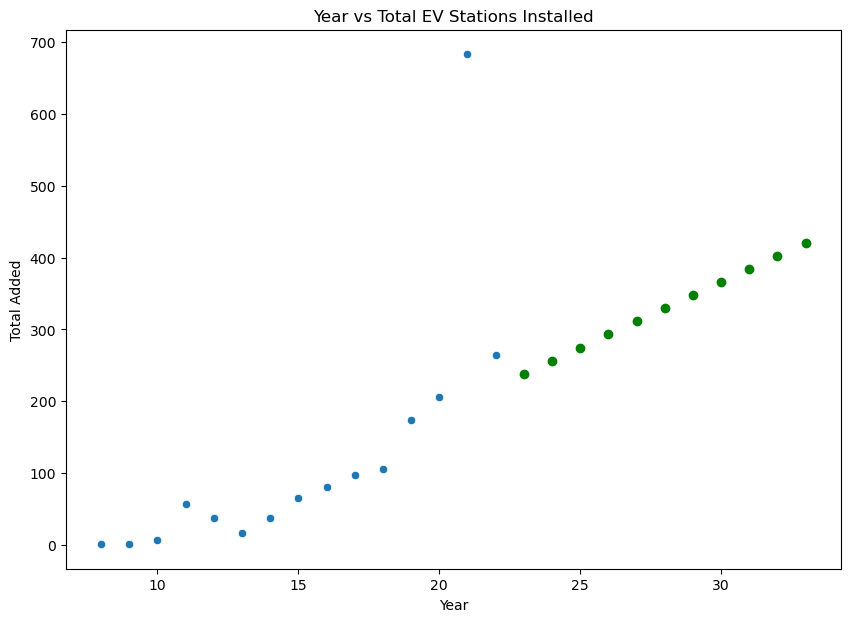

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# You haven't provided the values of X_train and y_train, so I'm going to
# use the years list as the x values and an array of zeros as the y values
# for this example.

x = [23,24,25,26,27,28,29,30,31,32,33]
y = np.zeros(len(x))

# You also haven't provided the classifier object, so I'm going to use a
# dummy object for this example.

# Now we can use the x and y values to plot the data

# Reshape the x array to be a 2D array of size (n, 1) where n is the
# number of elements in the array
x = np.array(x).reshape(-1, 1)

# Use the classifier object to predict the y values for the x values
y_pred = classifier.predict(x)

# Create a figure object with a specified size
fig = plt.figure(figsize=(10, 7))

# Add a title to the plot
plt.title('Year vs Total EV Stations Installed')

# Plot the x and y values as a scatterplot
sns.scatterplot(x="Year", y="Total_Installed", data=df)

# Plot the predicted y values against the x values as a scatter plot
plt.scatter(x, y_pred, color='green')
# Label the x and y axes
plt.xlabel('Year')
plt.ylabel('Total Added')

fig.savefig('Year Total EV Installed 2033.jpg', bbox_inches='tight', dpi=150)
print(y_pred)

In [40]:
#y_pred=y_pred.reshape(1,-1)
#print(y_pred.shape)
#x=x.reshape(1,-1)
#print(x.shape)
#print(y_pred)
#df_x = pd.DataFrame({'Year': x, 'Total_nstalled': y_pred} )

#df = df.append(df_x)
#df

In [41]:
# define a function that converts the year to the format "2008", "2009", etc.
def convert_year(year):
    return f"20{year}"

# apply the convert_year function to the year column of the dataframe
df["Year"] = df["Year"].apply(convert_year)

# use the replace method to replace "208" with "2008" and "209" with "2009"
df["Year"].replace({"208": "2008", "209": "2009"}, inplace=True)

# display the modified dataframe
df

,Year,Total_Installed
0,2008,1.0
1,2009,2.0
2,2010,7.0
3,2011,57.0
4,2012,38.0
5,2013,16.0
6,2014,38.0
7,2015,65.0
8,2016,81.0
9,2017,97.0


In [42]:
df

,Year,Total_Installed
0,2008,1.0
1,2009,2.0
2,2010,7.0
3,2011,57.0
4,2012,38.0
5,2013,16.0
6,2014,38.0
7,2015,65.0
8,2016,81.0
9,2017,97.0


In [43]:
df.to_csv('predicted_stations.csv')

In [44]:
#combined_data = pd.merge(EV_Vehicles, df, on="Year")
#combined_data

In [45]:
#X=np.array(combined_data["Year"].values)
#y=np.array(combined_data[ "Total_Sold"].values)

#X=X.reshape(-1,1)
#y=y.reshape(-1,1)


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)


#min_max_scaler = MinMaxScaler().fit(X_test)
#X_norm = min_max_scaler.transform(X)

#sc_x = StandardScaler()
#xtrain = sc_x.fit_transform(X_train) 
#xtest = sc_x.transform(X_test)
#print (xtrain[0:10, :])


#classifier = linear_model.LinearRegression()
#classifier.fit(X_train, y_train)

#classifier.predict(X_train)

#x=X_train
#y=y_train
#n = np.size(x)

#y_pred = classifier.predict(X_train)
#y_pred

In [46]:
#print('Variance score: {}'.format(classifier.score(X_test, y_test)))

In [47]:
# first neural network with keras tutorial
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [48]:
X=np.array(df["Year"].values)
y=np.array(df["Total_Installed"].values)

X=X.reshape(-1,1)
y=y.reshape(-1,1)
y.shape

(15, 1)

In [49]:
from tpot import TPOTRegressor
# Initialize the TPOT regressor.
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)

# Fit the regressor on the training data.
tpot.fit(X_train, y_train)

# Evaluate the model on the test set.
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1167.611111111111

Generation 2 - Current best internal CV score: -917.4

Generation 3 - Current best internal CV score: -917.4

Generation 4 - Current best internal CV score: -557.4726543079017

Generation 5 - Current best internal CV score: -557.4726543079017

Best pipeline: LassoLarsCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), normalize=False)
-42168.963582016484


In [50]:
# Use the TPOT regressor to make predictions on the new data.
predictions = tpot.predict(X_test)
predictions

array([104.94252133, 158.59730049,  22.33939784, 225.08790855,
        36.14044974])

In [51]:
last = total_installed[-1]

new_stations = np.subtract(y_pred, last)

print(new_stations) # number of new stations

[[-25.88712522]
 [ -7.60846561]
 [ 10.670194  ]
 [ 28.94885362]
 [ 47.22751323]
 [ 65.50617284]
 [ 83.78483245]
 [102.06349206]
 [120.34215168]
 [138.62081129]
 [156.8994709 ]]


In [52]:
# Filter the 'A' column of the dataframe to only include values less than 40
EV_Stations = EV_Stations.loc[EV_Stations['Latitude'] > 30]

# View the resulting dataframe
EV_Stations.head()

,ZIP,Latitude,Longitude,Access Code,Open Date,ID
51405,98503,47.044011,-122.822404,1,18,33351
51406,98188,47.443377,-122.296229,1,10,33717
51407,98502,47.035421,-122.938962,1,9,35337
51408,99252,47.673347,-117.388933,1,10,35620
51409,99201,47.654998,-117.425025,1,10,35621


In [53]:
def plotlonglat(data,filename):
    import folium
    import pandas as pd
    from folium.plugins import HeatMap

    #create a map
    this_map = folium.Map(prefer_canvas=True)

    def plotDot(point):
        '''input: series that contains a numeric named latitude and a numeric named longitude
        this function creates a CircleMarker and adds it to your this_map'''
        folium.CircleMarker(location=[point.Latitude, point.Longitude],
                            radius=2,
                            weight=5).add_to(this_map)

    #use df.apply(,axis=1) to "iterate" through every row in your dataframe
    data.apply(plotDot, axis = 1)

    #Set the zoom to the maximum possible
    this_map.fit_bounds(this_map.get_bounds())
    
    #Save the map to an HTML file
    this_map.save(filename)

    return this_map

In [54]:
plotlonglat(EV_Stations,"EV_Stations")

In [55]:
import csv
import pandas as pd
import datetime as dt
from os import listdir
import os
import numpy as np
from numpy import mean, sqrt, square, arange
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

#split the data
X = EV_Stations[['Open Date']]
#X = X.values.reshape((len(X),3))
y = EV_Stations[['Latitude', 'Longitude']]
#y = y.values.reshape((len(y),1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Create the model and predict
nn = 2

X_test = np.array(X_test)
weights = 'distance'
knn = neighbors.KNeighborsRegressor(nn, weights=weights)
X_new=X_test
y_pred = knn.fit(X_test, y_test).predict(X_new)

err = y_pred - y_test
rms = sqrt(mean(square(err)))

print (rms)

Latitude     0.792931
Longitude    1.505775
dtype: float64


In [56]:
df = pd.DataFrame(y_pred, columns=['Latitude', 'Longitude'])
df

,Latitude,Longitude
0,47.433727,-123.485090
1,46.904352,-120.754629
2,47.622770,-122.340148
3,46.636510,-122.459922
4,47.906696,-122.482116
...,...,...
546,47.906696,-122.482116
547,47.622770,-122.340148
548,47.577706,-122.312811
549,47.622770,-122.340148


In [57]:
plotlonglat(df,"predicted")

In [58]:
from tpot import TPOTRegressor
# Initialize the TPOT regressor
X=np.array(EV_Stations["Open Date"].values)
y=np.array(EV_Stations["Longitude"].values)

X=X.reshape(-1,1)
y=y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)

# Fit the regressor on the training data.
tpot.fit(X_train, y_train)

# Evaluate the model on the test set.
print(tpot.score(X_train, y_train))
print(X_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.8105706886639683

Generation 2 - Current best internal CV score: -1.8105706886639683

Generation 3 - Current best internal CV score: -1.8074337738920678

Generation 4 - Current best internal CV score: -1.8074337738920678

Generation 5 - Current best internal CV score: -1.8074337738920678

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=86, p=2, weights=distance)
-1.7727939072697756
[[21]
 [21]
 [21]
 ...
 [20]
 [21]
 [21]]


In [59]:
# Use the TPOT regressor to make predictions on the new data.
predictions_long_tpot = tpot.predict(X_train)
predictions_long_tpot

array([[-121.58139535],
       [-121.58139535],
       [-121.58139535],
       ...,
       [-121.31395349],
       [-121.58139535],
       [-121.58139535]])

In [60]:
from tpot import TPOTRegressor
# Initialize the TPOT regressor
X=np.array(EV_Stations["Open Date"].values)
y=np.array(EV_Stations["Latitude"].values)

X=X.reshape(-1,1)
y=y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)

# Fit the regressor on the training data.
tpot.fit(X_train, y_train)

# Evaluate the model on the test set.
print(tpot.score(X_train, y_train))
print(X_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.33592756331187706

Generation 2 - Current best internal CV score: -0.33591911019382464

Generation 3 - Current best internal CV score: -0.33591911019382464

Generation 4 - Current best internal CV score: -0.3358116447193641

Generation 5 - Current best internal CV score: -0.3358116447193641

Best pipeline: ExtraTreesRegressor(ZeroCount(input_matrix), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=7, min_samples_split=13, n_estimators=100)
-0.3298680315863571
[[21]
 [21]
 [21]
 ...
 [20]
 [21]
 [21]]


In [61]:
# Use the TPOT regressor to make predictions on the new data.
predictions_lat_tpot = tpot.predict(X_train)
predictions_lat_tpot

array([46.8715927 , 46.8715927 , 46.8715927 , ..., 46.91442565,
       46.8715927 , 46.8715927 ])

In [62]:
# combine the arrays into a dataframe
import pandas as pd

# flatten the array1 variable
predictions_long_tpot = predictions_long_tpot.flatten()
predictions_lat_tpot = predictions_lat_tpot.flatten()

df_tpot = pd.DataFrame(data={'Latitude': predictions_lat_tpot, 'Longitude': predictions_long_tpot})
# print the dataframe
df_tpot

,Latitude,Longitude
0,46.871593,-121.581395
1,46.871593,-121.581395
2,46.871593,-121.581395
3,46.951507,-121.779070
4,46.914426,-121.313953
...,...,...
1279,46.871593,-121.581395
1280,46.871593,-121.581395
1281,46.914426,-121.313953
1282,46.871593,-121.581395


In [63]:
plotlonglat(df_tpot,"predicted_tpot")

In [64]:
# Import the necessary modules
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#split the data
X = EV_Stations['Open Date'].values
#X = X.values.reshape((len(X),3))
y = EV_Stations['Latitude'].values
#y = y.values.reshape((len(y),1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

y_test = tf.convert_to_tensor(y_test)
y_train = tf.convert_to_tensor(y_train)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

print(X_train)
print(y_train)

# Define the model
model = keras.Sequential([
    # Add a dense layer with 11 neurons and an input shape of (1,), with l2 regularization
    keras.layers.Dense(1284, input_shape=(1,), kernel_regularizer=keras.regularizers.l2(0.0001)),
    # Add a sigmoid activation function
    keras.layers.Activation('relu'),
    # Add a dense layer with 1 neuron and a sigmoid activation function, with l2 regularization
    keras.layers.Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))
])

# Compile the model
model.compile(optimizer=tf.optimizers.Adam(), loss='mean_squared_error')

# Fit the model on the data
model.fit(X_train, y_train, epochs=70)

# Use the trained model to make predictions
predictions_lat = model.predict(X_train)
print(predictions_lat)
# Evaluate the model on the testing data
score = model.evaluate(X_train, y_train, verbose=0)
print(score)

tf.Tensor([21 21 21 ... 20 21 21], shape=(1284,), dtype=int64)
tf.Tensor([47 47 46 ... 45 47 46], shape=(1284,), dtype=int64)
Epoch 1/70
41/41 [==============================] - 1s 2ms/step - loss: 982.4854
Epoch 2/70
41/41 [==============================] - 0s 3ms/step - loss: 55.9093
Epoch 3/70
41/41 [==============================] - 0s 2ms/step - loss: 46.9846
Epoch 4/70
41/41 [==============================] - 0s 3ms/step - loss: 46.5720
Epoch 5/70
41/41 [==============================] - 0s 3ms/step - loss: 45.7067
Epoch 6/70
41/41 [==============================] - 0s 3ms/step - loss: 44.7963
Epoch 7/70
41/41 [==============================] - 0s 3ms/step - loss: 43.2419
Epoch 8/70
41/41 [==============================] - 0s 3ms/step - loss: 41.0375
Epoch 9/70
41/41 [==============================] - 0s 3ms/step - loss: 38.4173
Epoch 10/70
41/41 [==============================] - 0s 2ms/step - loss: 35.9378
Epoch 11/70
41/41 [==============================] - 0s 3ms/step - loss:

In [65]:
# Import the necessary modules
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#split the data
X = EV_Stations['Open Date'].values
X=abs(X)
#X = X.values.reshape((len(X),3))
y = EV_Stations['Longitude'].values
y=abs(y)
#y = y.values.reshape((len(y),1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

y_test = tf.convert_to_tensor(y_test)
y_train = tf.convert_to_tensor(y_train)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

print(X_train)
print(y_train)

# Define the model
model = keras.Sequential([
    # Add a dense layer with 11 neurons and an input shape of (1,), with l2 regularization
    keras.layers.Dense(1284, input_shape=(1,), kernel_regularizer=keras.regularizers.l2(0.0001)),
    # Add a sigmoid activation function
    keras.layers.Activation('selu'),
    # Add a dense layer with 1 neuron and a sigmoid activation function, with l2 regularization
    keras.layers.Dense(1, activation='selu', kernel_regularizer=keras.regularizers.l2(0.0001))
])

#softplus, selu, relu, elu
#selu, elu

# Compile the model
model.compile(optimizer=tf.optimizers.Adam(), loss='mean_squared_error')

# Fit the model on the data
model.fit(X_train, y_train, epochs=70)

# Use the trained model to make predictions
predictions_long = model.predict(X_train)
print(predictions_long)
# Evaluate the model on the testing data
score = model.evaluate(X_train, y_train, verbose=0)
print(score)

tf.Tensor([21 21 21 ... 20 21 21], shape=(1284,), dtype=int64)
tf.Tensor([122 122 119 ... 122 122 119], shape=(1284,), dtype=int64)
Epoch 1/70
41/41 [==============================] - 1s 3ms/step - loss: 7346.3950
Epoch 2/70
41/41 [==============================] - 0s 3ms/step - loss: 457.6982
Epoch 3/70
41/41 [==============================] - 0s 4ms/step - loss: 188.1959
Epoch 4/70
41/41 [==============================] - 0s 3ms/step - loss: 178.8068
Epoch 5/70
41/41 [==============================] - 0s 3ms/step - loss: 173.0852
Epoch 6/70
41/41 [==============================] - 0s 4ms/step - loss: 167.0945
Epoch 7/70
41/41 [==============================] - 0s 4ms/step - loss: 160.5508
Epoch 8/70
41/41 [==============================] - 0s 3ms/step - loss: 153.9193
Epoch 9/70
41/41 [==============================] - 0s 3ms/step - loss: 147.0339
Epoch 10/70
41/41 [==============================] - 0s 3ms/step - loss: 139.8809
Epoch 11/70
41/41 [==============================] - 0s 

In [66]:
import numpy as np
# Apply minus operator to each element of array
predictions_long = -predictions_long
print(predictions_long)

[[-121.52533 ]
 [-121.52533 ]
 [-121.52533 ]
 ...
 [-121.780876]
 [-121.52533 ]
 [-121.52533 ]]


In [67]:
predictions_lat=predictions_lat.reshape(-1,1)
print(predictions_lat)

[[47.261223]
 [47.261223]
 [47.261223]
 ...
 [47.254147]
 [47.261223]
 [47.261223]]


In [68]:
zipped = list(zip(predictions_long,predictions_lat))
df_nn = pd.DataFrame(zipped, columns=['Longitude','Latitude'])
df_nn.head()

,Longitude,Latitude
0,[-121.52533],[47.261223]
1,[-121.52533],[47.261223]
2,[-121.52533],[47.261223]
3,[-121.231476],[47.268326]
4,[-121.780876],[47.254147]


In [69]:
plotlonglat(df_nn,"Predicted NN")